##Brincando com a analise da basa do movie lens##

Uma analise de dados na Netflix e queira explorar as semelhanças e diferenças no gosto das pessoas em filmes com base em como eles avaliam diferentes filmes.

Analisaremos as classificações de filmes individuais, mas vamos começar mostrando como as classificações de gêneros se comparam.

O conjunto de dados tem dois arquivos. Vamos importá-los para os quadros de dados do pandas:

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import helper

# Import da base de filmes
movies = pd.read_csv('C:/Users/ASUS/Music/PojetoNetflix/Base/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
# Import da base de notas
ratings = pd.read_csv('C:/Users/ASUS/Music/PojetoNetflix/Base/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Qual o tamanho das bases?

In [32]:
print('O dataset contem: ', len(ratings), ' notas de ', len(movies), ' filmes.')

O dataset contem:  100836  notas de  9742  filmes.


##Romance vs. Scifi##

Pegando um subconjunto de usuários e tentar ver quais são seus gêneros preferidos. Estamos ocultando o maior número de pré-processamento de dados nas funções auxiliares, portanto, o foco está no tópico de clustering.

In [34]:
# Calcular a classificação média de romance e filmes de ficção científica

genre_ratings = helper.get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
userId,,
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


A função get_genre_ratings calculou a classificação média de cada usuário de todos os filmes de romance e todos os filmes de ficção científica. 
Vamos distorcer um pouco nosso conjunto de dados removendo pessoas que gostem tanto de ficção científica quanto de romance, apenas para que nossos grupos tendam a defini-los como gostando de um gênero mais do que do outro.

In [12]:
biased_dataset = helper.bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "numero de registro: ", len(biased_dataset))
biased_dataset.head()

numero de registro:  162


,userId,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


Assim, podemos ver que temos 162 usuários e, para cada usuário, temos a classificação média dos filmes de romance e ficção científica que eles assistiram.

Vamos traçar este conjunto de dados:

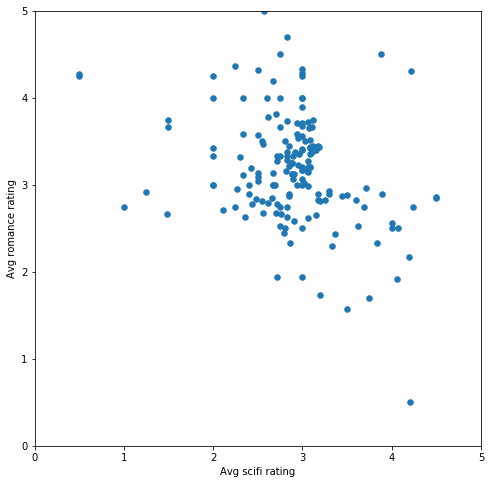

In [13]:
%matplotlib inline

helper.draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

Como seria se dividirmos a amostra em dois grupos usando k-means?


In [14]:
# Vamos transformar nosso conjunto de dados em uma lista
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

Importar KMeans
Prepar KMeans com n_clusters = 2
O conjunto de dados X para o método fit_predict do KMeans e recupear os rótulos de agrupamento em previsões

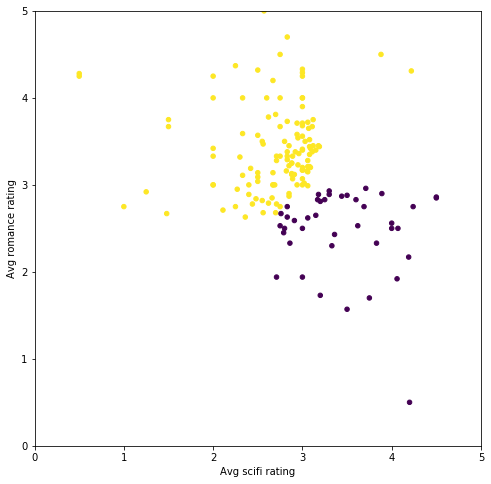

In [15]:
# Importa KMeans
from sklearn.cluster import KMeans 

# Criar uma instância do KMeans para encontrar dois clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict para agrupar o conjunto de dados
predictions = kmeans_1.fit_predict(X)

# Plot
helper.draw_clusters(biased_dataset, predictions)

Podemos ver que os grupos são baseados principalmente em como cada pessoa classifica os filmes de romance. Se a sua classificação média de filmes de romance for superior a 3 estrelas, então pertencem a um grupo. Caso contrário, eles pertencem ao outro grupo.

e se for 3 grupos?

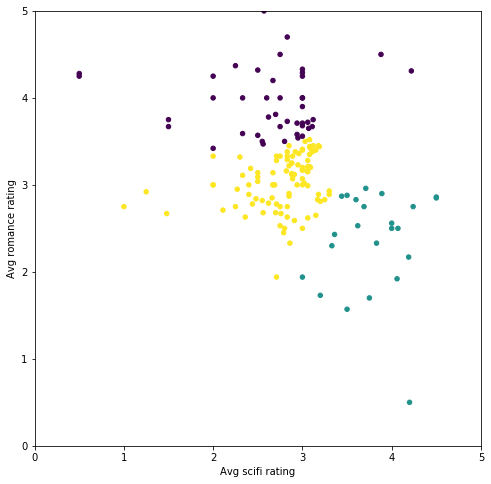

In [17]:
# Criar uma instância do KMeans para encontrar 3 clusters
kmeans_2 = KMeans(n_clusters=3)

# Use fit_predict para agrupar o conjunto de dados
predictions_2 = kmeans_2.fit_predict(X)

# Plot
helper.draw_clusters(biased_dataset, predictions_2)

assim temos:
- pessoas que gostam de romance, mas não de ficção científica
- pessoas que gostam de ficção científica mas não de romance
- pessoas que gostam de scifi e romance
- Vamos adicionar mais um grupo

e com 4?

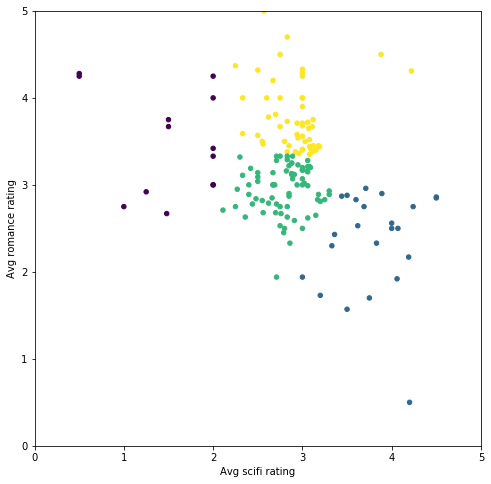

In [20]:
# Criar uma instância do KMeans para encontrar 4 clusters
kmeans_3 = KMeans(n_clusters =4)

# Use fit_predict para agrupar o conjunto de dados
predictions_3 = kmeans_3.fit_predict(X)

# Plot
helper.draw_clusters(biased_dataset, predictions_3)

Assim, podemos ver que quanto mais clusters nós dividimos em nosso conjunto de dados, mais semelhantes são os gostos da população de cada cluster.

###Escolhendo K###

Qual é o número certo de clusters para este conjunto de dados?
vamos olhar para um simples chamado "o método do cotovelo". O método do cotovelo trabalha plotando os valores ascendentes de k versus o erro total calculado usando aquele k.
Como calculamos o erro total? Uma maneira de calcular o erro é o erro quadrado. Digamos que estamos calculando o erro para k = 2. Nós teríamos dois grupos cada um com um ponto "centróide". Para cada ponto em nosso conjunto de dados, subtraímos suas coordenadas do centróide do cluster ao qual ele pertence. Em seguida, ajustamos o resultado dessa subtração (para nos livrarmos dos valores negativos) e somamos os valores. Isso nos deixaria com um valor de erro para cada ponto. Se somarmos esses valores de erro, obteríamos o erro total para todos os pontos quando k = 2.

In [21]:
# testar para saber o valor de k
# Nós adicionamos um passo de 5 para melhorar o desempenho. Nós não precisamos calcular o erro para cada valor de k
possible_k_values = range(2, len(X)+1, 5)

# Calcular valores de erro para todos os valores k nos quais estamos interessados
errors_per_k = [helper.clustering_errors(k, X) for k in possible_k_values]

In [23]:
# observe os valores de K em relação à pontuação da silhueta da execução de K-means com esse valor de k
list(zip(possible_k_values, errors_per_k))

[(2, 0.37651376343962917),
 (7, 0.3703455325689512),
 (12, 0.37209646608630775),
 (17, 0.3800638235619168),
 (22, 0.3634285571325411),
 (27, 0.39894152518550835),
 (32, 0.41106079826709613),
 (37, 0.42836601364458565),
 (42, 0.4113843820371501),
 (47, 0.39766784979665804),
 (52, 0.39172917146822),
 (57, 0.40326795035687146),
 (62, 0.4082574886431653),
 (67, 0.396428170725429),
 (72, 0.37795932529058734),
 (77, 0.38720357324358984),
 (82, 0.3601233969917304),
 (87, 0.3597260475501559),
 (92, 0.34043198688124643),
 (97, 0.3210446353519418),
 (102, 0.3082137150008128),
 (107, 0.2701117517646),
 (112, 0.26899508748826645),
 (117, 0.249422653680449),
 (122, 0.23842270108802946),
 (127, 0.22332039332817585),
 (132, 0.21179996908298948),
 (137, 0.19143078514136877),
 (142, 0.1745705045298946),
 (147, 0.13831784871757571),
 (152, 0.10665923446292466),
 (157, 0.06172839506172839),
 (162, 0.06172839506172839)]

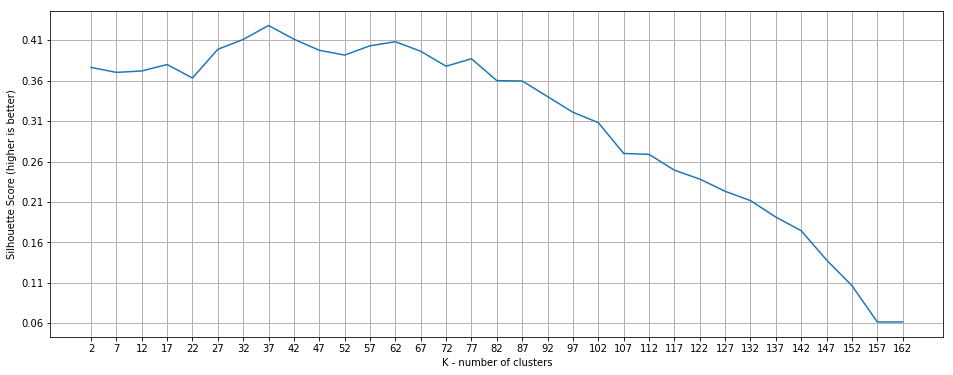

In [24]:
# Plotar o valor de cada K em relação ao valor da silhueta nesse valor
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

picos no gravifo so que muitos grupos é ruim de se vê

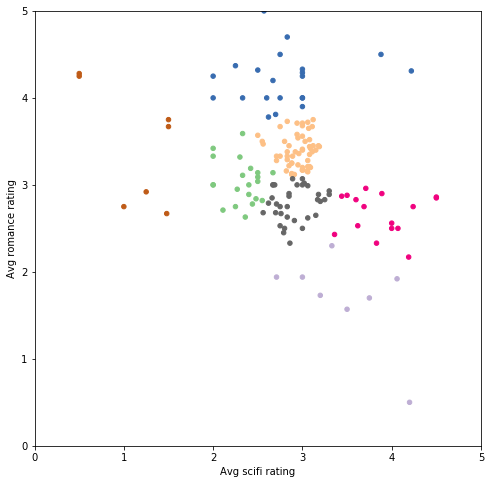

In [25]:
# Criar uma instância do KMeans para encontrar 7 clusters
kmeans_4 = KMeans(n_clusters =7)

# Use fit_predict para agrupar o conjunto de dados
predictions_4 = kmeans_4.fit_predict(X)

# plot
helper.draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Jogar outro gênero na mistura. Vamos adicionar o gênero Action.

In [26]:
biased_dataset_3_genres = helper.get_genre_ratings(ratings, movies, 
                                                     ['Romance', 'Sci-Fi', 'Action'], 
                                                     ['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
biased_dataset_3_genres = helper.bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

print( "Numero de registro: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Numero de registro:  161


,userId,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


In [27]:
X_with_action = biased_dataset_3_genres[['avg_scifi_rating',
                                         'avg_romance_rating', 
                                         'avg_action_rating']].values

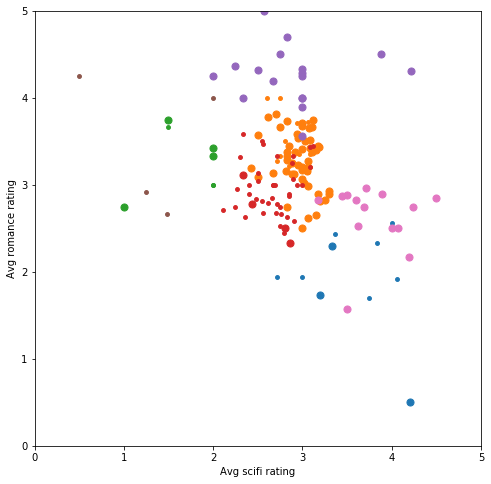

In [28]:
# Criar uma instância do KMeans para encontrar 7 clusters
kmeans_5 = KMeans(n_clusters=7)

# Use fit_predict para agrupar o conjunto de dados
predictions_5 = kmeans_5.fit_predict(X_with_action)

# plot
helper.draw_clusters_3d(biased_dataset_3_genres, predictions_5)

Os eixos xey para scifi e romance, respectivamente. Usando o tamanho do ponto para codificar aproximadamente a classificação de 'ação' (grande ponto para média de classificações acima de 3, pequeno ponto caso contrário).